## Iskanje strukture v podatkih

Podatkovno rudarjenje, naloga, `5. 4. 2019`  
**Mitja Hrovatič**

## Search for structure in data

Data mining, assignment, `<INSERT DATE>`  
**`<INSERT Name and surname>`**

Z modeliranjem skušamo poiskati strukturo v podatkih. Z metodami nenadzorovanga modeliranja skušamo poiskati skupine podobnih podatkov oz. skupine primerov.

V nalogi boste uporabili modeliranje verjetnostnih porazdelitev za iskanje osamelcev ter metode za iskanje skupin podobnih primerov (gručenje).

By modeling, we try to find structure in the data. Using unsupervised modeling methods, we try to find groups of similar data or cases.

In this homework you will use modeling of probability distributions for searching for outliers and methods for finding groups of similar cases (clustering).

### Podatki

Opis podatkovne zbirke MovieLens ostaja enak prvi nalogi.

In [1]:
from csv import DictReader
from datetime import datetime
import numpy as np
from scipy.stats import multivariate_normal as mvn 
import math
from operator import itemgetter, attrgetter
import itertools

%matplotlib inline
%config InlineBackend.figure_formats = ['jpg']
import matplotlib
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')


# Shranjeni podatki
movies = {}
zanr = {}
cast = {}
ratings_movie = {}
ratings_user = {}
tags = []
links = []
actors = {}
users = {}



with open('podatki/ml-latest-small/movies.csv', 'rt', encoding='utf-8') as data:
    for row in DictReader(data):
        movies[row['movieId']] = row
        for genre in row['genres'].split('|'):
            if genre not in zanr:
                zanr[genre] = [genre]
            else:
                zanr[genre] += [genre]
        
with open('podatki/ml-latest-small/ratings.csv', 'rt', encoding="utf-8") as data:
    for row in DictReader(data):
        if row['movieId'] not in ratings_movie:
            ratings_movie[row['movieId']] = []
        ratings_movie[row['movieId']].append([float(row['rating']), int(row['timestamp'])])
        
        if row['movieId'] not in ratings_user:
            ratings_user[row['movieId']] = []
        ratings_user[row['movieId']].append([int(row['userId']), float(row['rating'])])
        
        if row['userId'] not in users:
            users[row['userId']] = []
        users[row['userId']].append([float(row['rating']), row['movieId']])
        
    for key, value in ratings_movie.items():
        ratings_movie[key] = np.array(value)
    
    for key, value in ratings_user.items():
        ratings_user[key] = np.array(value)
    
    for key, value in users.items():
        users[key] = np.array(value)
        
    
        
with open('podatki/ml-latest-small/cast.csv', 'rt', encoding="utf-8") as data:
    for row in DictReader(data):
        cast[row['movieId']] = row['cast'].split("|")
        
    for key, value in cast.items():
        for actor in value:
            if actor not in actors:
                actors[actor] = []
            actors[actor] += [key]
        
with open('podatki/ml-latest-small/tags.csv', 'rt', encoding="utf-8") as data:
    for row in DictReader(data):
        tags.append(row)
        
with open('podatki/ml-latest-small/links.csv', 'rt', encoding="utf-8") as data:
    for row in DictReader(data):
        links.append(row)

### Data

The description of the MovieLens database remains the same as for the first homework.

### Vprašanja

Z uporabo principov, ki ste jih spoznali na vajah in predavanjih, odgovorite na
spodnja vprašanja. Pri vsakem vprašanju dobro premislite, na kakšen način boste
najbolje podali, prikazali oz. utemeljili odgovor. Bistven del so odgovori na
vprašanja in ne toliko implementacija vaše rešitve.

### Questions

By using the principles you have learned on exercises and lectures, answer the 
following questions. For each question, think carefully about the best way to give, show or justify the answer. The essential part is the answers to the
questions and not so much the implementation of your solution.

#### 1. Iskanje osamelcev (50%) 
O ocenah katerih filmov so si uporabniki najmanj enotni? Povedano drugače, za katere filme so pripadajoče ocene najbolj razpršene?

Formuliraj problem kot modeliranje verjetnostne porazdelitve. Premisli o naslednjih vprašanjih, naredi ustrezne poizkuse in odgovori.

#### 1. Finding outliers (50%)
About the ratings of which movies are the users the least unified? In other words, for which films are the corresponding scores the most dispersed?

Formulate the problem as modeling the probability distribution. Think about the following questions, make the appropriate experiments and answers.

In [2]:
from scipy.stats import beta

list_of_std = []
list_of_avg = []
for key, value in ratings_movie.items():
    ocene_filma = value[:, 0]
    n = len(ocene_filma)
    if n > 15:
        povp = np.mean(ocene_filma)
        std = math.sqrt((sum([(x - povp) ** 2 for x in ocene_filma]) / (n - 1)))
        list_of_std.append((key, std, n))
        list_of_avg.append(std)



count = 0
list_of_std = sorted(list_of_std, reverse=True, key=itemgetter(1))
for title, std, st_ocn in list_of_std:
    if count == 10:
          break
    print(f'{movies[title]["title"]} --> {std}')
    count += 1

Cook the Thief His Wife & Her Lover, The (1989) --> 1.6186052764450243
Deadpool (2016) --> 1.5582376504126059
Event Horizon (1997) --> 1.5219085168290627
Battlestar Galactica (2003) --> 1.3989792196965818
Brokeback Mountain (2005) --> 1.3865113750357219
Saw (2004) --> 1.3811844390035148
Bicentennial Man (1999) --> 1.3770409689131835
Patch Adams (1998) --> 1.3767725467565968
13 Going on 30 (2004) --> 1.3666188418222285
Mad Max: Fury Road (2015) --> 1.3648821289058084


Odgovor: **Nalogo sem rešil tako, da sem za vsak film izračunal standardni odklon ter izpisal prvih deset filmov, ki imajo ocene najbolj razpršene. Večji kot je standardni odklon bolj so ocene razpršene oz. uporabniki so si manj enotni. V izračunu sem upošteval filme, ki so prejeli več kot 15 ocen, zaradi bolj pravičnega izračuna, saj filmi, ki imajo malo število ocen, za njih težje presodimo, koliko so si uporabniki zares enotni oz. neenotni.**

Answer: **You can write the answer in multiple cells**

#### 1.1. vprašanje:

Katera je ustrezna naključna spremenljivka (količina) v podatkih, ki odgovarja na vprašanje?        

#### 1.1. question:

What is the appropriate random variable (quantity) in the data that answers the question?

Odgovor: **Standardni odklon**

Answer: **You can write the answer in multiple cells**

#### 1.2. vprašanje:
Nariši njeno porazdelitev, npr., s pomočjo histograma.

#### 1.2. question:
Draw its distribution, for example, using a histogram.

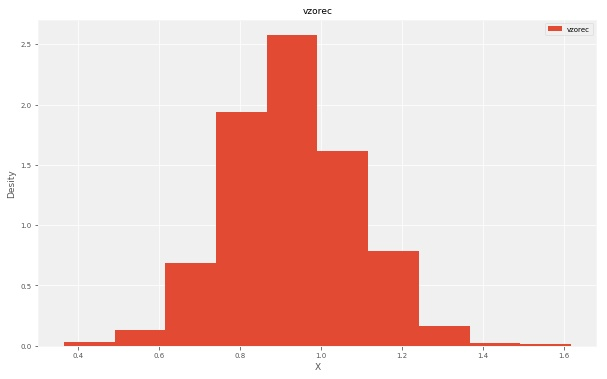

In [3]:
list_of_avg = sorted(list_of_avg)

# Histogram - porazdelitev naključnih VZORCEV x glede na P(x)
plt.figure(figsize=(10, 6))
plt.title("vzorec")
plt.hist(list_of_avg, label="vzorec", density=True)

plt.xlabel("X")
plt.ylabel("Desity")
plt.legend()

Odgovor: **odgovor lahko zapišete v več celic**

Answer: **You can write the answer in multiple cells**

#### 1.3. vprašanje:

Ali porazdelitev spominja na kakšno znano porazdelitev? Ali je porazdelitev morda normalna ali katera druga? 

#### 1.3. question:

Does the distribution remind you of a known distribution? Is the distribution possibly normal or some other?

Odgovor: **Menim, da je bolj podobna obliki Studentove porazdelitve.**

Answer: **You can write the answer in multiple cells**

#### 1.4. vprašanje:

Oceni parametre te porazdelitve s pomočjo postopkov, ki smo jih spoznali na vajah.  Izmed porazdelitev, ki smo jih spoznali na vajah, izberi tisto, ki se podatkom najbolj prilega.        

#### 1.4. question:

Assess the parameters of this distribution by means of the procedures we have learned at the exercises. From the distributions we have learned at the exercises, choose the one that best fits the data.

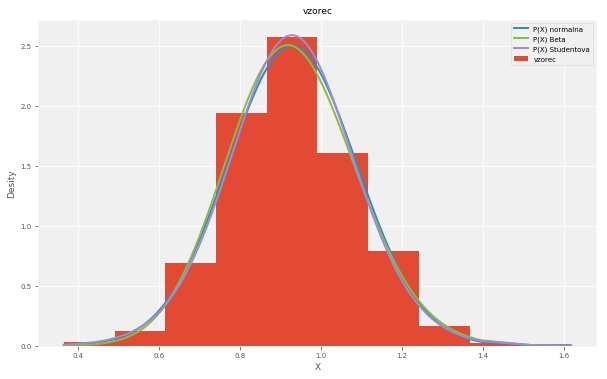

In [8]:
list_of_avg = sorted(list_of_avg)

mu     = np.mean(list_of_avg)   # sredina
sigma2 = np.var(list_of_avg)   # varianca
P      = [mvn.pdf(x, mu, sigma2) for x in list_of_avg]  # porazdelitvena funkcija

# Histogram - porazdelitev naključnih VZORCEV x glede na P(x)
plt.figure(figsize=(10, 6))
plt.title("vzorec")
plt.hist(list_of_avg,    label="vzorec", density=True)
plt.plot(list_of_avg, P, label="P(X) normalna", linewidth=2.0)


# Beta porazdelitev
from scipy.stats import beta

parameters = beta.fit(list_of_avg)
P_fit = [beta.pdf(x, *parameters) for x in list_of_avg]

plt.plot(list_of_avg, P_fit, label="P(X) Beta", linewidth=2.0)


# Studentova porazdelitev
from scipy.stats import t as student

pars = student.fit(list_of_avg)
P_fit = [student.pdf(x, *pars) for x in list_of_avg]

plt.plot(list_of_avg, P_fit, label="P(X) Studentova", linewidth=2.0)


plt.xlabel("X")
plt.ylabel("Desity")
plt.legend()

Odgovor: **Vse porazdelitve so si zelo blizu, vendar menim, da se najbolj prilega Studentova poradelitev, saj se najbolj približa vrhu histograma.**

Answer: **You can write the answer in multiple cells**

#### 1.5. vprašanje:

Izpiši filme z vrednostjo naključne spremenljivke, ki spada v zgornjih 5% statistično značilnih primerov. 

#### 1.5. question:

Print movies with the value of a random variable that falls in the top 5% of the statistically significant cases.

In [5]:
list_of_pet_procent = sorted(list_of_std, reverse=True, key=itemgetter(1))
zgornjih_pet_procent = list_of_pet_procent[:int(len(list_of_pet_procent) * 0.05)]

# print(len(zgornjih_pet_procent))
for title, std, st_ocn in zgornjih_pet_procent:
#     print(f'{title} --> {std} --> {st_n} --> {ocn}')
    print(f'{movies[title]["title"]} --> {std}')

Cook the Thief His Wife & Her Lover, The (1989) --> 1.6186052764450243
Deadpool (2016) --> 1.5582376504126059
Event Horizon (1997) --> 1.5219085168290627
Battlestar Galactica (2003) --> 1.3989792196965818
Brokeback Mountain (2005) --> 1.3865113750357219
Saw (2004) --> 1.3811844390035148
Bicentennial Man (1999) --> 1.3770409689131835
Patch Adams (1998) --> 1.3767725467565968
13 Going on 30 (2004) --> 1.3666188418222285
Mad Max: Fury Road (2015) --> 1.3648821289058084
Little Nicky (2000) --> 1.3482620136740262
European Vacation (aka National Lampoon's European Vacation) (1985) --> 1.3228756555322954
Life Aquatic with Steve Zissou, The (2004) --> 1.3210124494589806
Blair Witch Project, The (1999) --> 1.3189272472154525
Lost Highway (1997) --> 1.3118889555061235
Scary Movie (2000) --> 1.3097577888546668
Dirty Rotten Scoundrels (1988) --> 1.308397784278452
Pay It Forward (2000) --> 1.3048253407872157
Secret of Roan Inish, The (1994) --> 1.2976222599091634
8 1/2 (8½) (1963) --> 1.29039977485

Odgovor: **Zgornjih 78 rezultatov spada v zgornjih 5% statistično značilnih primerov. Rezultate sem pridobil tako, da sem izračunal koliko je takih primerov ter jih izpisal iz padajoče urejenega seznama.**

Answer: **You can write the answer in multiple cells**

#### 2. Gručenje filmov (50%)

Priporočilni sistemi pogosto odkrivajo skupine predmetov (v našem primeru filme), za katere velja visoka podobnost. 

Poiščite 100 najbolj gledanih filmov. Ali med njimi obstajajo skupine?
Uporabite ustrezen algoritem za gručenje. Na film lahko gledamo kot vektor, kjer je  
število komponent enako številu uporabnikov. 

Vektorji vsebujejo tudi *neznane vrednosti*.
Primer vektorjev za deset filmov prikazuje spodnja tabela.

Algoritme gručenja lahko izvajamo v izvornem prostoru (koordinatni sistem filmi-uporabniki) ali pa filme primerjamo z merami podobnosti, ki smo jih spoznali na vajah. 
Premisli, kateri način je primernejši glede na obliko podatkov.

#### 2. Clustering films (50%)

Recommendation systems often detect groups of objects (in our example films), which are of high similarity.

Find the 100 most watched movies. Are there groups among them?
Use the appropriate clustering algorithm. We can watch the film as a vector where the
number of components is equal to the number of users.

Vectors also contain *unknown values*.
An example of the vectors for ten films is shown in the table below.

Clustering algorithms can be performed in the original space (the coordinate system films-users), or we can compare the films with the similarities we have learned on the exercises.
Think about which method is more appropriate in terms of the data format.

| x          |Movie                                      | $u_0$ |$u_1$ | $u_2$ | $\cdots$ |
|------------|-------------------------------------------|:-----:|:----:|:------|:--------:|
|$\vec{x_0}$ | Fight Club (1999)                         | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_1}$ | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | ?     | ?    | 2.5   | $\cdots$ |
|$\vec{x_2}$ | Independence Day (a.k.a. ID4) (1996)      | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_3}$ | Dances with  Wolves (1990)                | 4.0   | ?    | ?     | $\cdots$ |
|$\vec{x_4}$ | Fargo (1996)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_5}$ | Speed (1994)                              | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_6}$ | Apollo 13 (1995)                          | ?     | 2.0  | ?     | $\cdots$ |
|$\vec{x_7}$ | Seven (a.k.a. Se7en) (1995)               | ?     | ?    | ?     | $\cdots$ |
|$\vec{x_8}$ | Sixth Sense, The (1999)                   | 3.0   | ?    | 4.0   | $\cdots$ |
|$\vec{x_9}$ | Aladdin (1992)                            | ?     | ?    | ?     | $\cdots$ |
|$\cdots$    | $\cdots$                                  | $\cdots$ | $\cdots$  | $\cdots$ | $\cdots$ |

Pri tem odgovori na naslednja vprašanja.

In [6]:
najbolj_gledani_list = sorted(list_of_std, reverse=True, key=itemgetter(2))[:100]
najbolj_gledani = {}
list_of_najbolj_gledani = []
list_of_titles_najbolj_gledani = []

st_users = len(users)

for title, std, st_n in najbolj_gledani_list:
    if title not in najbolj_gledani:
        najbolj_gledani[title] = []
    for key, value in users.items():
        for user_rate, movie_of in value:
            if movie_of == title:
                najbolj_gledani[title] += [float(user_rate)]
                break
        else:
            najbolj_gledani[title] += [0.0]


for title, std, st_n in najbolj_gledani_list:
    print(f'{movies[title]["title"]}')
    

for key, value in najbolj_gledani.items():
    list_of_najbolj_gledani.append(value)
    list_of_titles_najbolj_gledani.append(movies[key]["title"])
          


Forrest Gump (1994)
Pulp Fiction (1994)
Shawshank Redemption, The (1994)
Silence of the Lambs, The (1991)
Star Wars: Episode IV - A New Hope (1977)
Jurassic Park (1993)
Matrix, The (1999)
Toy Story (1995)
Schindler's List (1993)
Terminator 2: Judgment Day (1991)
Star Wars: Episode V - The Empire Strikes Back (1980)
Braveheart (1995)
Back to the Future (1985)
Fargo (1996)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
American Beauty (1999)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode VI - Return of the Jedi (1983)
Aladdin (1992)
Fugitive, The (1993)
Dances with Wolves (1990)
Fight Club (1999)
Seven (a.k.a. Se7en) (1995)
Usual Suspects, The (1995)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lion King, The (1994)
Apollo 13 (1995)
Godfather, The (1972)
True Lies (1994)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Batman (1989)
Sixth Sense, The (1999)
Saving Private Ryan (1998)
Men in Black (a.k.a. MIB) (1997)
Lord of the Rings: The Two

In doing so, answer the following questions.

#### 2.1. vprašanje:

Utemelji izbiro algoritma in mere podobnosti.

#### 2.1. question:

Justify the choice of algorithm and similarity measures.

Odgovor: **Uporabil sem hirarhično gručenje, zato ker se mi je zdelo nabolj primereno, saj gruči na podlagi mere razdalj, jaz pa sem naredil seznam vektorjem ocen za posamezne filme. Filmi katerih mera radalje je dovolj si blizu, so v isti skupini.**

Answer: **You can write the answer in multiple cells**

#### 2.2. vprašanje:

Koliko skupin filmov je med izbranimi? Ali poznamo kvantitativne ocene za različne možnosti razvrščanja v skupine?

#### 2.2. question:

How many groups of films are among the selected? Do we know the quantitative estimates for the various grouping options?

Odgovor: **Med izbranimi filmi je prišlo do sedmih različnih skupin.**

Answer: **You can write the answer in multiple cells**

#### 2.3. vprašanje:

Prikaži rezultate z uporabo ustrezne vizualizacije.

#### 2.3. question:

Display results using an appropriate visualization.

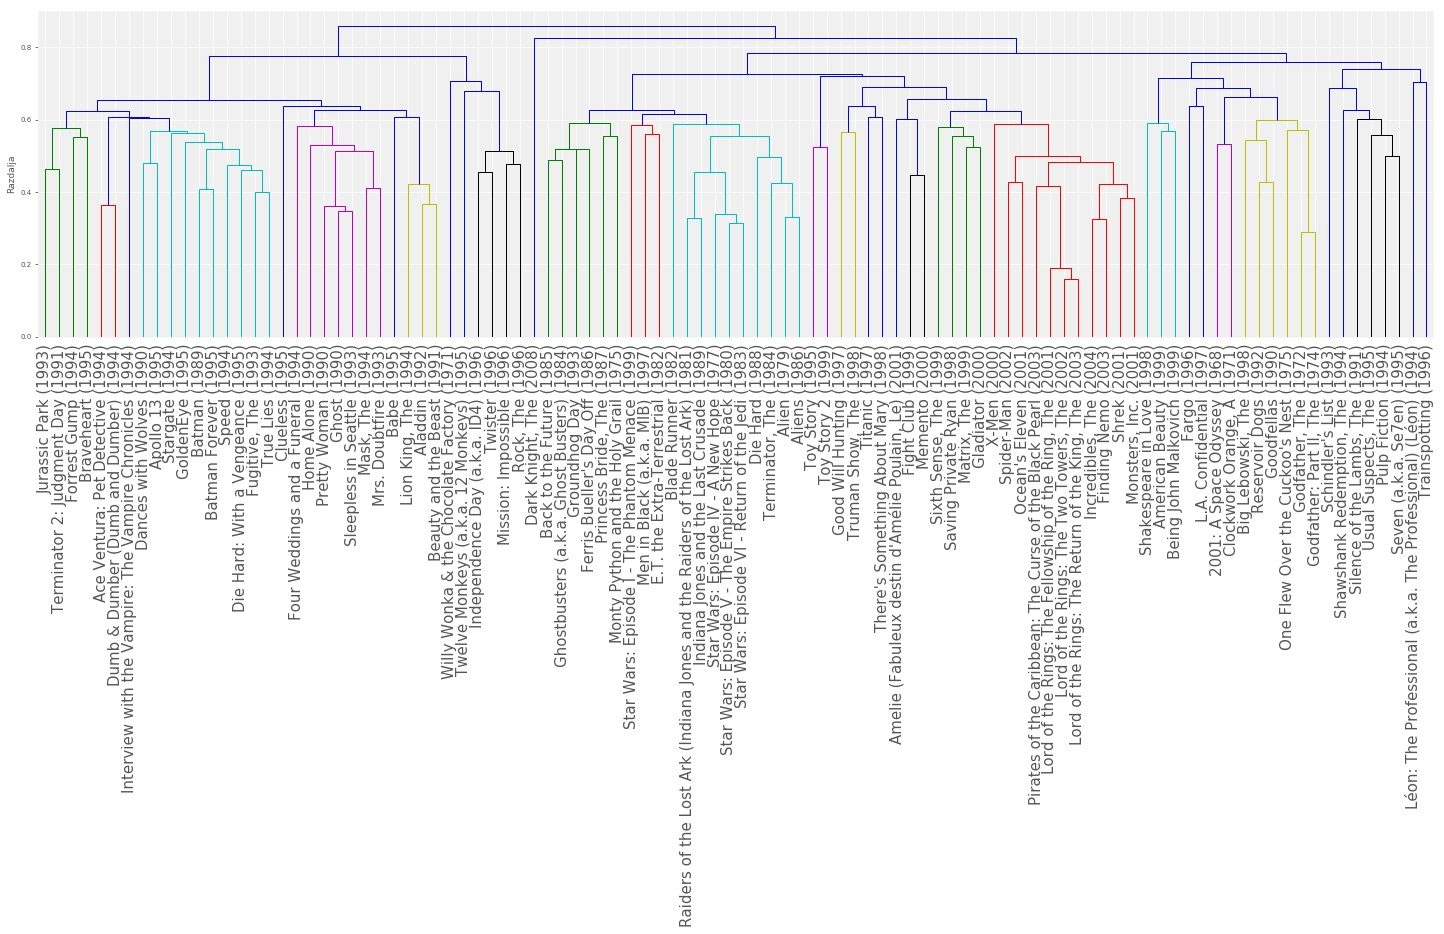

In [7]:
# kodo lahko razdelite v več celic
import scipy.cluster.hierarchy as sch
L = sch.linkage(list_of_najbolj_gledani, method="average", metric="correlation")
plt.figure(figsize=(25, 6))
D      = sch.dendrogram(L, labels=list_of_titles_najbolj_gledani, leaf_font_size=15)
plt.ylabel("Razdalja")
plt.show()

Odgovor: **odgovor lahko zapišete v več celic**

Answer: **You can write the answer in multiple cells**

#### 2.4. vprašanje:

Komentiraj smiselnost dobljenih rezultatov.

#### 2.4. question:

Comment on the validity of the results obtained.

Odgovor: **Po vizualni predstavitvi z dengrogramom, lahko vidimo, da so filmi oz. vse njihove epizode, kot npr. Lord of the Rings, Toy Story, Star Wars, v enakih skupinah, tako, da menim, da je bilo gručenje uspešno.**

Answer: **You can write the answer in multiple cells**